In [2]:
%load_ext autoreload

In [36]:
%autoreload
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from functools import partial
from itertools import chain
from tqdm.auto import tqdm
from jax.experimental.optimizers import adam, momentum
import jax.scipy.stats as stats
import jax.experimental.stax as stax
from jx.utils import progress_bar_scan
from jax.flatten_util import ravel_pytree
from jax.config import config
import optax
config.update("jax_enable_x64", True)

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['figure.figsize'] = (11, 7)

In [4]:
key = jax.random.PRNGKey(0)

# SDE methods

In [34]:
@jax.jit
def lerp(t0, t1, y0, y1, t):
    return (y0 * (t1 - t) + y1 * (t - t0)) / (t1 - t0)

@jax.jit
def gaussian_kld(mu1, sigma1, mu2, sigma2):
    return jnp.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2. * sigma2**2) - 0.5
    
@jax.jit
def noise(key, dt):
    return jax.random.normal(key) * jnp.sqrt(dt)

In [8]:
@partial(jax.jit, static_argnums=(0, 1, 3))
def _sdeint_step_euler(drift, diffusion, params, aug_fn, y, t0, t1, key):
    dt = t1 - t0
    
    dft = drift(y, t0, params)
    dfn = diffusion(y, t0, params)
    dW = noise(key, dt)
    
    y = y + dft * dt + dfn * dW
    
    if aug_fn:
        aug = aug_fn(y, t0, params)
    else:
        aug = None
    
    return y, (y, aug)

@partial(jax.jit, static_argnums=(0, 1, 3))
def _sdeint_step_milstein(drift, diffusion, params, aug_fn, y, t0, t1, key):
    dt = t1 - t0
    
    dft = drift(y, t0, params)
    dfn = diffusion(y, t0, params)
    dfn_grad = jax.grad(diffusion)(y, t0, params)
    dW = noise(key, dt)
    
    y = y + dft * dt + dfn * dW + 0.5 * dfn * dfn_grad * (dW**2 - dt)
    
    if aug_fn:
        aug = aug_fn(y, t0, params)
    else:
        aug = None

    return y, (y, aug)

def _sdeint(drift, diffusion, y0, t, params, key, dt, maxiter, sdeint_step, aug_fn=None):

    @jax.jit
    def step_once(carry):
        t_prev, t_curr, t_obs, y_prev, y_curr, aug, key = carry
        t_next = jnp.minimum(t_curr + dt, t[-1])
        t_prev, y_prev = t_curr, y_curr
        key, subkey = jax.random.split(key)
        _, y_aug = sdeint_step(
            drift,
            diffusion, 
            params, 
            None if aug_fn is None else aug_fn, 
            y_curr, 
            t_curr,
            t_next,
            subkey
        )
        y_curr, aug = y_aug
        t_curr = t_next
        carry = (t_prev, t_curr, t_obs, y_prev, y_curr, aug, key)
        return carry, None

    @jax.jit
    def no_op(carry):
        return carry, None

    @jax.jit
    def body_inner(carry, x):
        return jax.lax.cond(carry[1] < carry[2], step_once, no_op, carry)

    @jax.jit
    def body_outer(carry, x):
        t_prev, t_curr, _, y_prev, y_curr, aug_fn, key = carry
        t_obs = x
        carry = t_prev, t_curr, t_obs, y_prev, y_curr, aug_fn, key
        carry, _ = jax.lax.scan(
            body_inner, 
            carry, 
            None, 
            length=maxiter
        )
        t_prev, t_curr, t_obs, y_prev, y_curr, aug, key = carry
        y_store = lerp(t_prev, t_curr, y_prev, y_curr, t_obs)
        return carry, (y_store, aug)

    t_prev = t_curr = t[0]
    y_prev = y_curr = y0
    ys = jnp.array([y0])
    augs = jnp.array([0.])
    
    carry = (t_prev, t_curr, 0., y_prev, y_curr, 0. if aug_fn else None, key)

    _, y_aug = jax.lax.scan(body_outer, carry, t[1:])

    ys = jnp.concatenate((ys, y_aug[0]))
    
    if y_aug[1] is None:
        return ys, None
    else:
        augs = jnp.concatenate((augs, y_aug[1]))
        return ys, augs

def sdeint_maker(sde, t, dt=None, method='milstein', batch=False):
    
    has_aug = 'aug' in sde.keys()
    max_step = jnp.max(jnp.diff(t))
    if dt is None:
        dt = max_step / 1.9
    
    if method == 'euler':
        sdeint_step = _sdeint_step_euler
    elif method == 'milstein':
        sdeint_step = _sdeint_step_milstein
    else:
        raise

    @partial(jax.jit, static_argnames=["drift", 'diffusion', 'dt', 'maxiter', 'aug_fn'])
    def sdeint(
        y0,
        t, 
        params, 
        key, 
        drift=sde['drift'], 
        diffusion=sde['diffusion'],
        dt=dt,
        maxiter=jnp.ceil(max_step / dt).astype(int), 
        aug_fn=sde['aug'] if has_aug else None,
    ):
        return _sdeint(
            drift=drift, 
            diffusion=diffusion, 
            y0=y0, 
            t=t,
            params=params, 
            key=key, 
            dt=dt, 
            maxiter=maxiter, 
            sdeint_step=sdeint_step, 
            aug_fn=aug_fn, 
        )
    
    return sdeint

# Make an Ornstein-Uhlenbeck process

In [8]:
# define the SDE
ou = dict(
    drift = lambda y, t, p: p['theta'] * (p['mu'] - y),
    diffusion = lambda y, t, p: jnp.exp(p['sigma'])
)

# create some initial parameters for the SDE
params = dict(
    theta=2.,
    mu=1.,
    sigma=-1.,
)

CPU times: user 813 ms, sys: 2.84 ms, total: 816 ms
Wall time: 811 ms
CPU times: user 24 µs, sys: 12 µs, total: 36 µs
Wall time: 40.8 µs


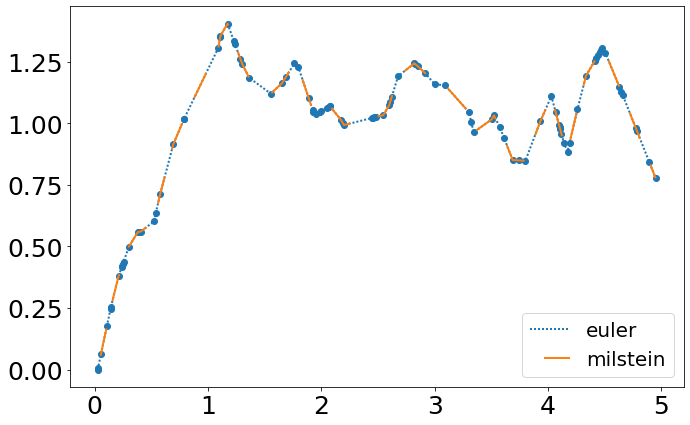

In [9]:
# run sdeint with two different integrators
x = jnp.sort(jax.random.uniform(key, minval=0., maxval=5., shape=(100,)))
sdeint = sdeint_maker(ou, x)
for m, ls in zip(['euler', 'milstein'], [(1, 1, 1), (0, 7, 7)]):
    %time y = sdeint(y0=0., t=x, params=params, key=key)[0]
    plt.plot(x, y, label=m, dashes=ls, lw=2)
plt.legend(fontsize=20)
plt.scatter(x, y)

# define MSE loss function and its gradient

In [154]:
run_sde = lambda p, k: sdeint(y0=0., t=x, params=p, key=k)[0]
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

# fit to data to get best SDE parameters 

In [155]:
opt_init, opt_update, get_params = momentum(1e-4, 0.9)
opt_state = opt_init(params)

niter = 200
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

# opt_state, losses = jax.lax.scan(
#     pbar(step), 
#     opt_state, 
#     (jnp.arange(niter), keys)
# )

losses = []
for i in (pbar := tqdm(range(niter))):
    opt_state, loss = step(opt_state, (i, keys[i]))
    pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

params = get_params(opt_state)

  0%|          | 0/200 [00:00<?, ?it/s]

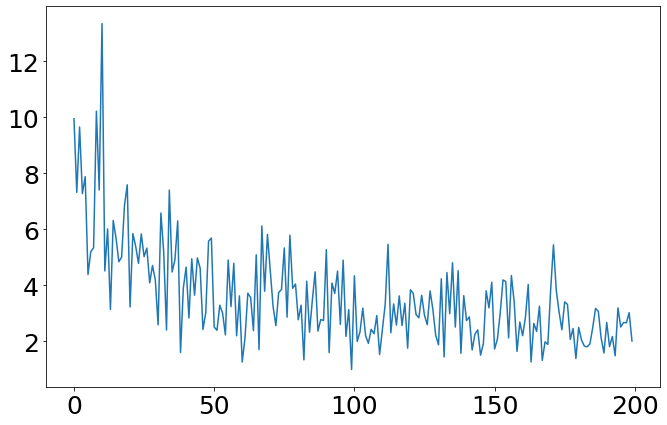

In [156]:
plt.plot(losses)

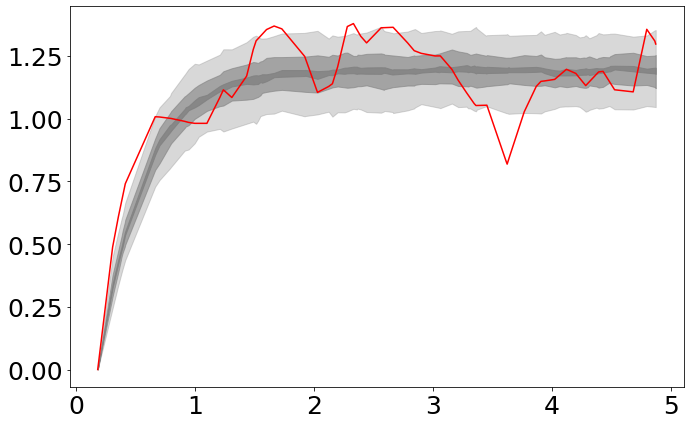

In [157]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')

# Replace drift and diffusion terms with neural networks 

In [158]:
drift_init, drift_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

diffusion_init, diffusion_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

# make SDE

In [159]:
sde_nn = dict(
    drift = jax.jit(lambda y, t, p: drift_apply(p['drift'], y)[0][0]),
    diffusion = jax.jit(lambda y, t, p: diffusion_apply(p['diffusion'], y)[0][0])
)

# define loss

In [160]:
sdeint = sdeint_maker(sde=sde_nn, t=x, method='euler')
run_sde = jax.jit(lambda p, k: sdeint(y0=y[0], t=x, params=p, key=k)[0])
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

# initialize SDE/network parameters

In [161]:
key, k1, k2 = jax.random.split(key, 3)
_, p_drift_init = drift_init(k1, (1,))
out_shape, p_diffusion_init = diffusion_init(k2, (1,))
nn_params = dict(
    drift = p_drift_init,
    diffusion = p_diffusion_init,
)

# optimize SDE/neural network parameters

In [162]:
opt_init, opt_update, get_params = adam(1e-2)
opt_state = opt_init(nn_params)

niter = 200
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

losses = []
for i in (pbar := tqdm(range(niter))):
    opt_state, loss = step(opt_state, (i, keys[i]))
    pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

# opt_state, losses = jax.lax.scan(
#     pbar(step), 
#     opt_state, 
#     (jnp.arange(niter), keys)
# )

nn_params = get_params(opt_state)

  0%|          | 0/200 [00:00<?, ?it/s]

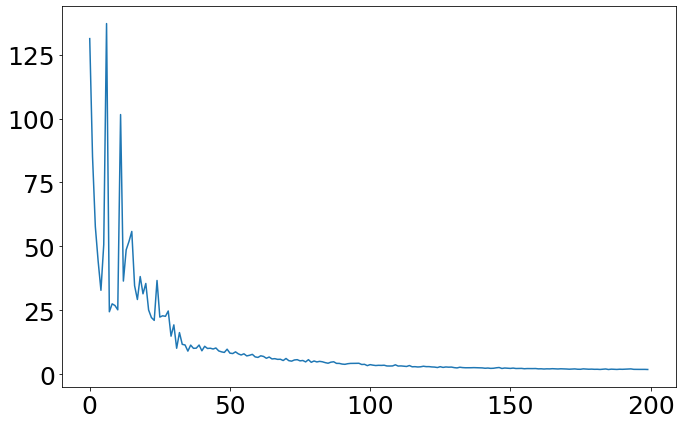

In [163]:
plt.plot(losses)

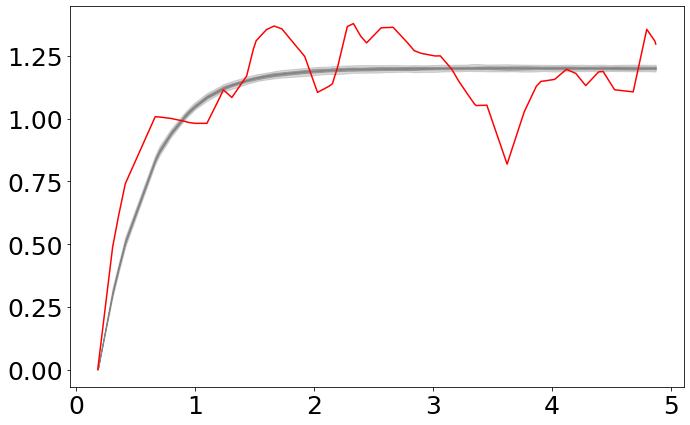

In [164]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(nn_params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')

# diffusion term seems to go to 0, need to regularize

# 
-----------
#

# adapted from torchsde latent_sde.py example

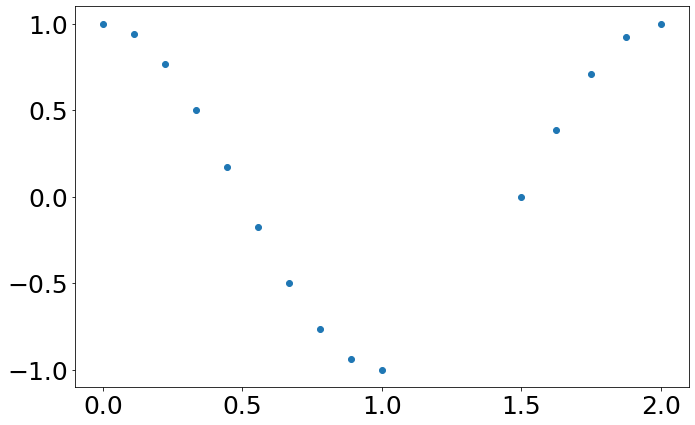

In [76]:
x = jnp.concatenate((jnp.linspace(0., 1., 10), jnp.linspace(1.5, 2, 5)))
y = jnp.cos(x * jnp.pi)
plt.scatter(x, y)

In [77]:
def f(y, t, p): 
    i = jnp.array((jnp.sin(t), jnp.cos(t), y))
    return drift_apply(p['drift'], i)[0]

In [78]:
def g(y, t, p):
    # return 1.
    return p['sigma']

In [79]:
def h(y, t, p):
    # return 2. * (0. - y)
    return p['theta'] * (p['mu'] - y)

In [80]:
def aug_fn(y, t, p):
    f_out, g_out, h_out = f(t, y, p), g(t, y, p), h(t, y, p)
    u = (f_out - h_out) / g_out
    logqp = 0.5 * u**2
    return logqp

In [81]:
drift_init, drift_apply = stax.serial(
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(1),
)

In [136]:
key, k1, k2 = jax.random.split(key, 3)
out_shape, p_drift_init = drift_init(k1, (3,))

params = dict(
    drift = p_drift_init,
    sigma = 2.,
    theta = 1.,
    mu = 0.,
    qy0_mean = 0.,
    qy0_logstd = 0.,
    py0_mean = 0.,
)
params['py0_logstd'] = jnp.log(jnp.sqrt(params['sigma']**2 / (2. * params['theta'])))

In [137]:
sde = dict(
    drift = f,
    diffusion = g,
    aug = aug_fn,
)
sde_prior = dict(
    drift = h,
    diffusion = g,
)
sdeint = jax.jit(sdeint_maker(sde, x, dt=0.1))
sdeint_prior = jax.jit(sdeint_maker(sde_prior, x, dt=0.1))

In [138]:
def loss_fn(params, keys, ts, bounds):
    eps = jax.random.normal(keys[0])
    y0 = params['qy0_mean'] + eps * jnp.exp(params['qy0_logstd'])
    logqp0 = gaussian_kld(params['qy0_mean'], jnp.exp(params['qy0_logstd']), params['py0_mean'], jnp.exp(params['py0_logstd']))
    ts_ext = jnp.concatenate((jnp.array([bounds[0]]), ts, jnp.array([bounds[1]])))
    ys, logqps = jax.vmap(sdeint, in_axes=(None, None, None, 0))(y0, ts_ext, params, keys)
    ys = ys[:,1:-1]
    logqps = logqps[:,1:-1]
    logpy = stats.laplace.logpdf(ys, loc=y, scale=0.05).sum(axis=-1).mean()
    kl = (logqp0 + logqps).sum(axis=-1).mean()
    loss = -logpy + kl
    return loss

loss_vg = jax.jit(jax.value_and_grad(loss_fn))

In [139]:
@jax.jit
def sample_q(t, params, keys):
    eps = jax.random.normal(keys[0], shape=(keys.shape[0],))
    y0 = params['qy0_mean'] + eps * jnp.exp(params['qy0_logstd'])
    ys, _ = jax.vmap(sdeint, in_axes=(0, None, None, 0))(y0, t, params, keys)
    return ys

In [140]:
@jax.jit
def sample_p(t, params, keys):
    eps = jax.random.normal(keys[0], shape=(keys.shape[0],))
    y0 = params['py0_mean'] + eps * jnp.exp(params['py0_logstd'])
    ys, _ = jax.vmap(sdeint_prior, in_axes=(0, None, None, 0))(y0, t, params, keys)
    return ys

In [144]:
opt = optax.multi_transform(
    {k: optax.adam(1e-2) if k in ["drift", "qy0_mean", "qy0_logstd"] else optax.set_to_zero() for k in params.keys() },
    {k: k for k in params.keys()}
)
opt_state = opt.init(params)

In [152]:
niter = 500
batch_size = 128

keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, params, key):
    keys = jax.random.split(key, batch_size)
    loss, grad = loss_vg(params, keys, x, (-1., 4))
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return opt_state, params, loss

losses = []
for i in (pbar := tqdm(range(niter))):
    opt_state, params, loss = step(opt_state, params, keys[i])
    pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

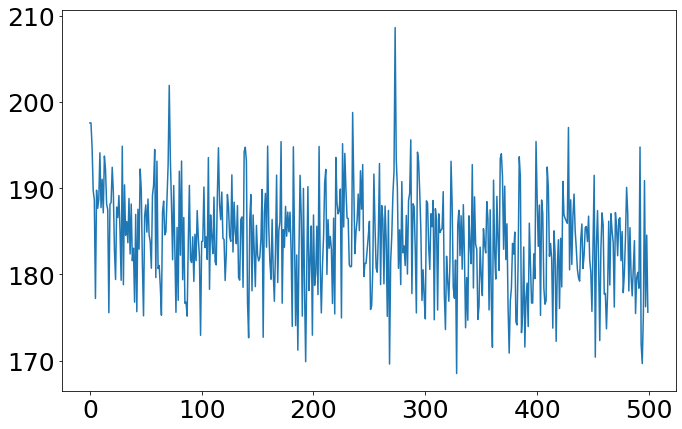

In [153]:
plt.plot(losses)

CPU times: user 119 ms, sys: 27.3 ms, total: 146 ms
Wall time: 105 ms


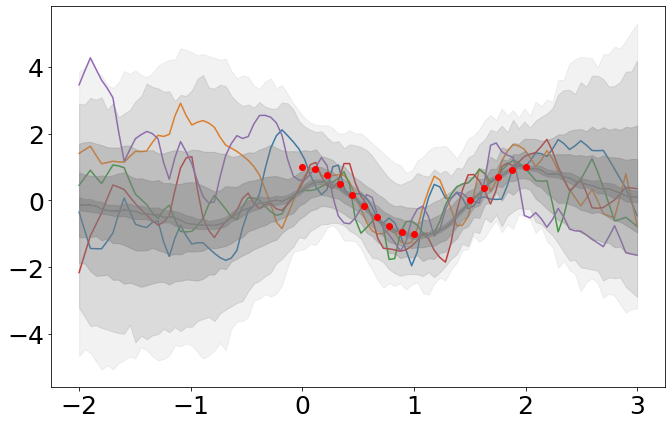

In [154]:
%%time
xnew = jnp.linspace(-2., 3., 100)
ys = sample_q(xnew, params, keys)
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 1.]
percentiles = [0.999, 0.99, 0.9, 0.75, 0.55, 0.5]
for a, p in zip(alphas, percentiles):
    plt.fill_between(xnew, *jnp.quantile(ys, jnp.array([1. - p, p]), axis=0), alpha=a, color='gray')
plt.scatter(x, y, c='r')
for i in range(5):
    plt.plot(xnew, ys[i], zorder=-1)